In [3]:
# ! pip install wandb opencv-python-headless==4.1.2.30 albumentations torch-summary timm==0.5.4 einops joblib icecream  -qq -U

In [22]:
import warnings
from glob import glob
import pathlib
from pathlib import Path
from torchsummary import summary
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import gc
import cv2
import copy
import time
import random
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd
from einops import rearrange, repeat
from scipy import stats

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import timm

import json

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [5]:

# ENV = 'COLAB'
ENV = 'KAGGLE'
# ENV = 'SYSTEM'

# Option for Mixed Precision
# FP16 = True
FP16 = False


CONFIG = dict(
    nickname='tf_efficientnetv2_m',
    seed=42,
    backbone='tf_efficientnetv2_m',
    embedder=None,
    train_batch_size=8,
    valid_batch_size=32,
    img_size=384,
    num_epochs=5,
    early_stopping=True,
    early_stopping_step=10,
    learning_rate=1e-4,
    scheduler='CosineAnnealingLR',
    min_lr=1e-6,
    T_max=100,
    num_classes=25,
    weight_decay=1e-6,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    competition='lg',
    _wandb_kernel='deb'
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


set_seed(CONFIG['seed'])


In [7]:
import wandb
run = wandb.init(project="lg",
                 entity="jiwon7258",
                 config=CONFIG,
                 job_type='inf',
                 id = 'koxrlhhf',
                 resume= 'must',
                 )

run.name = CONFIG['nickname']

dataset = wandb.run.use_artifact(
    'jiwon7258/lg/lg:v1', type='dataset')


# Download the artifact's contents
dataset_dir = dataset.download()
dataset_dir = Path(dataset_dir)


# Augmentation

In [53]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05,
                           rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15,
                   b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(),
        ToTensorV2()], p=1.)
}


# Dataset Dataloader

In [9]:
TEST_PATH =  dataset_dir / 'test'

In [10]:
test_csv = sorted(glob(str(TEST_PATH / '*/*.csv')))
test_jpg = sorted(glob(str(TEST_PATH / '*/*.jpg')))

In [54]:
# # TTA
# class TestDataset(Dataset):
#     def __init__ (self, N, test_imgs, transforms = None):
#         self.N = N
#         self.test_imgs = test_imgs
#         self.transforms = transforms


#     def __len__ (self):
#         return len(self.test_imgs)

#     def __getitem__(self, index):
#         img_path = self.test_imgs[index]
#         img_code = (Path(img_path)).parent.stem
#         img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
#         imgs = [self.transforms(image=img)['image'] for _ in range(self.N)]
#         imgs = np.concatenate(imgs, axis = 0)
#         imgs = rearrange(imgs, '(new1 bs) h w -> new1 bs h w', new1=self.N)

#         return imgs, img_code

# testDataset = TestDataset(8, test_jpg, transforms = data_transforms['train'])
# testDataloader = DataLoader(
#     testDataset, batch_size=CONFIG['valid_batch_size'], shuffle=False)


In [ ]:
class TestDataset(Dataset):
    def __init__(self, N, test_imgs, transforms=None):
        self.N = N
        self.test_imgs = test_imgs
        self.transforms = transforms

    def __len__(self):
        return len(self.test_imgs)

    def __getitem__(self, index):
        img_path = self.test_imgs[index]
        img_code = (Path(img_path)).parent.stem
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(image=img)['image']

        return img, img_code


testDataset = TestDataset(0, test_jpg, transforms=data_transforms['valid'])
testDataloader = DataLoader(
    testDataset, batch_size=CONFIG['valid_batch_size'], shuffle=False)


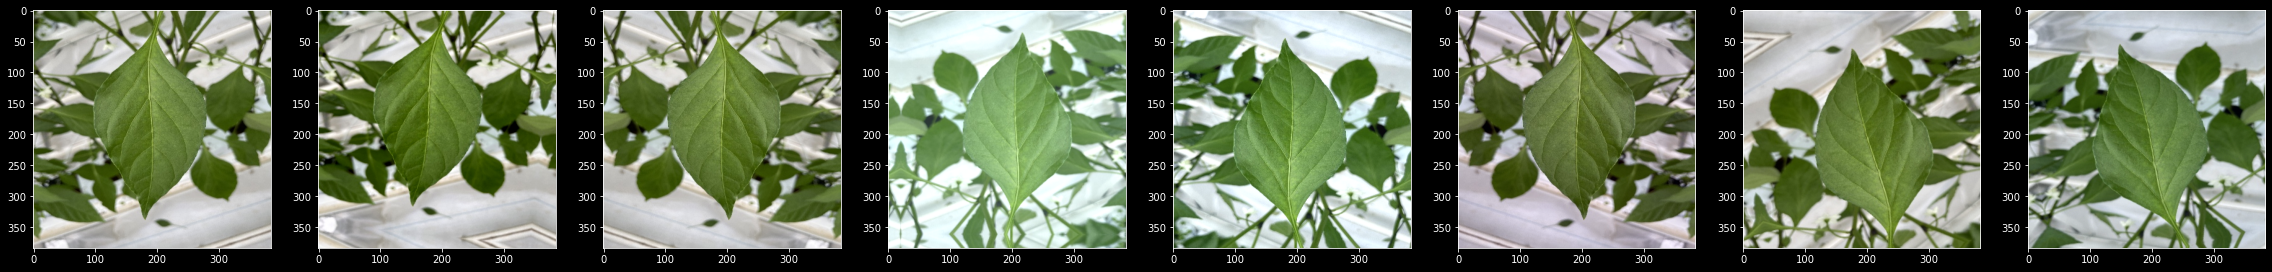

In [56]:
# for imgs, img_code in testDataset :
#     fig, axes = plt.subplots(1,8, figsize = (40,20))
#     for i in range(8):
#         img = imgs[i, :, :, :]
#         axes[i].imshow(img.reshape(384,384,3))
#     break

In [19]:
for img, img_code in testDataloader:
    print(type(img))
    print(img.shape)
    print(img_code)
    print(type(img_code))
    break


<class 'torch.Tensor'>
torch.Size([2, 8, 3, 384, 384])
('10000', '10001')
<class 'tuple'>


# Key Value Dict

In [ ]:
wandb.restore('class_dict', run_path='jiwon7258/lg/1lkvc6n0', root='./')
class_dict = joblib.load('class_dict')

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self, backbone, embedder, pretrained=True):
        super(Model, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.n_features = 1280
        self.fc = nn.Linear(self.n_features, CONFIG['num_classes'])

    def forward(self, images):
        # features = (bs, embedding_size)
        features = self.backbone(images)
        # outputs  = (bs, num_classes)
        output = self.fc(features)
        return output


model = Model(CONFIG['backbone'], CONFIG['embedder'], pretrained=True)
model.to(CONFIG['device'])


In [ ]:
wandb.restore('last.bin', 'jiwon7258/lg/koxrlhhf', root='./')
model.load_state_dict(torch.load('last.bin',
                                  map_location=CONFIG['device']))


In [ ]:
# # TTA
# img_code_list = []
# outputs = []
# with torch.no_grad():
#     model.eval()

#     bar = tqdm(enumerate(testDataloader), total=len(testDataloader))

#     for step, (imgs, img_codes) in bar:
#         # imgs : (bs, N, C, H, W), torch.Tensor
#         # img_codes (bs, N), list(str)
#         imgs = imgs.to(CONFIG['device'])
#         imgs = rearrange(imgs, 'bs N C H W -> (bs N) C H W')
#         logits = model(imgs)
#         # logits : ( (bs * N), num_classes)
#         logits = logits.detach().cpu()
#         logits = rearrange(
#             logits, '(bs N) num_classes -> bs N num_classes', bs=CONFIG['valid_batch_size'])
#         output = np.argmax(torch.softmax(logits, dim=-1), axis=-1)
#         output = np.array(output)
#         # (bs, N)
#         output = stats.mode(output, axis=1)[0].reshape(-1)
#         # (bs)
#         output = [class_dict[i] for i in output]

#         print(img_codes)
#         print(output)

#         img_code_list.extend(img_codes)
#         outputs.extend(output)


In [ ]:
# no TTA
with torch.no_grad():
    model.eval()

    img_code_list = []
    outputs = []
    bar = tqdm(enumerate(testDataloader), total=len(testDataloader))

    for step, (img, img_code) in bar:
        img = img.to(device)
        logits = model(img)
        # (bs, num_classes)

        logits = logits.detach().cpu()
        output = np.argmax(torch.softmax(logits, dim=-1), axis=-1)
        output = np.array(output)
        output = [class_dict[i] for i in output]

        img_code_list.extend(img_code)
        outputs.extend(output)

        assert len(img_code_list) == len(outputs)




In [ ]:
result = pd.DataFrame()
result['image'] = img_code_list
result['label'] = outputs
result.to_csv('submit.csv',index= False, index_label=False)